In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report


data_dir = "./asl_alphabet_train/asl_alphabet_train"
batch_size  = 32
num_epochs  = 50
num_classes = 29
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# ========== Image preprocessing ==========
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [3]:
# ========== Load and partition the dataset ==========
full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)
total_len    = len(full_dataset)
val_len      = int(total_len * 0.15)
test_len     = int(total_len * 0.15)
train_len    = total_len - val_len - test_len

train_ds, val_ds, test_ds = random_split(full_dataset, [train_len, val_len, test_len])
val_ds.dataset.transform  = val_test_transform
test_ds.dataset.transform = val_test_transform

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=4)


In [ ]:
# ========== Initialize MobileNetV2 ==========
model = models.mobilenet_v2(pretrained=True)
# Freeze feature extraction layer
for param in model.features.parameters():
    param.requires_grad = False


in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=5e-4,weight_decay=1e-4)


D:\Users\Manson\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Users\Manson\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# ===== Training function =====
def train_model(model, train_loader, val_loader, epochs):
    best_acc = 0.0
    history  = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader,
                                  desc=f"Epoch {epoch+1}/{epochs} Train",
                                  leave=False, dynamic_ncols=True):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss     += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc  = running_corrects.double() / len(train_loader.dataset)

        # Validation
        model.eval()
        val_running_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(
                val_loader,
                desc=f"Epoch {epoch+1}/{epochs} Validation",
                leave=False, dynamic_ncols=True
            ):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_corrects     += torch.sum(preds == labels)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc  = val_corrects.double() / len(val_loader.dataset)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc.item())
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc.item())

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f} Train Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Val Acc={val_acc:.4f}")

        
        if val_acc > best_acc:
            best_acc = val_acc
            os.makedirs("models", exist_ok=True)
            torch.save(model.state_dict(), "models/best_mobilenetv2.pth")
        

    return history

In [6]:
# ========== Drawing functions ==========
def plot_history(history):
    epochs = range(1, len(history["train_loss"])+1)
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"],   label="Val Loss")
    plt.title("Loss Curve"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"],   label="Val Acc")
    plt.title("Accuracy Curve"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
    plt.tight_layout(); plt.show()

Epoch 1/50 Train:   0%|                                                                       | 0/1904 [00:00<…

Epoch 1/50 Validation:   0%|                                                                   | 0/408 [00:00<…

Epoch 1: Train Loss=1.8514 Train Acc=0.6576 | Val Loss=0.9881 Val Acc=0.8649


Epoch 2/50 Train:   0%|                                                                       | 0/1904 [00:00<…

Epoch 2/50 Validation:   0%|                                                                   | 0/408 [00:00<…

Epoch 2: Train Loss=0.8475 Train Acc=0.8580 | Val Loss=0.5951 Val Acc=0.9122


Epoch 3/50 Train:   0%|                                                                       | 0/1904 [00:00<…

Epoch 3/50 Validation:   0%|                                                                   | 0/408 [00:00<…

Epoch 3: Train Loss=0.5850 Train Acc=0.8888 | Val Loss=0.4239 Val Acc=0.9261


Epoch 4/50 Train:   0%|                                                                       | 0/1904 [00:00<…

Epoch 4/50 Validation:   0%|                                                                   | 0/408 [00:00<…

Epoch 4: Train Loss=0.4637 Train Acc=0.9039 | Val Loss=0.3470 Val Acc=0.9377


Epoch 5/50 Train:   0%|                                                                       | 0/1904 [00:00<…

Epoch 5/50 Validation:   0%|                                                                   | 0/408 [00:00<…

Epoch 5: Train Loss=0.3911 Train Acc=0.9170 | Val Loss=0.2784 Val Acc=0.9480


Epoch 6/50 Train:   0%|                                                                       | 0/1904 [00:00<…

Epoch 6/50 Validation:   0%|                                                                   | 0/408 [00:00<…

Epoch 6: Train Loss=0.3451 Train Acc=0.9212 | Val Loss=0.2521 Val Acc=0.9499


Epoch 7/50 Train:   0%|                                                                       | 0/1904 [00:00<…

Epoch 7/50 Validation:   0%|                                                                   | 0/408 [00:00<…

Epoch 7: Train Loss=0.3088 Train Acc=0.9287 | Val Loss=0.2248 Val Acc=0.9552


Epoch 8/50 Train:   0%|                                                                       | 0/1904 [00:00<…

Epoch 8/50 Validation:   0%|                                                                   | 0/408 [00:00<…

Epoch 8: Train Loss=0.2868 Train Acc=0.9314 | Val Loss=0.1949 Val Acc=0.9608


Epoch 9/50 Train:   0%|                                                                       | 0/1904 [00:00<…

Epoch 9/50 Validation:   0%|                                                                   | 0/408 [00:00<…

Epoch 9: Train Loss=0.2646 Train Acc=0.9359 | Val Loss=0.1804 Val Acc=0.9631


Epoch 10/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 10/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 10: Train Loss=0.2523 Train Acc=0.9367 | Val Loss=0.1690 Val Acc=0.9634


Epoch 11/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 11/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 11: Train Loss=0.2389 Train Acc=0.9395 | Val Loss=0.1565 Val Acc=0.9670


Epoch 12/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 12/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 12: Train Loss=0.2320 Train Acc=0.9401 | Val Loss=0.1450 Val Acc=0.9715


Epoch 13/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 13/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 13: Train Loss=0.2201 Train Acc=0.9421 | Val Loss=0.1398 Val Acc=0.9710


Epoch 14/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 14/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 14: Train Loss=0.2130 Train Acc=0.9435 | Val Loss=0.1311 Val Acc=0.9703


Epoch 15/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 15/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 15: Train Loss=0.2048 Train Acc=0.9450 | Val Loss=0.1275 Val Acc=0.9720


Epoch 16/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 16/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 16: Train Loss=0.1992 Train Acc=0.9466 | Val Loss=0.1277 Val Acc=0.9727


Epoch 17/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 17/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 17: Train Loss=0.1960 Train Acc=0.9459 | Val Loss=0.1238 Val Acc=0.9723


Epoch 18/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 18/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 18: Train Loss=0.1894 Train Acc=0.9489 | Val Loss=0.1160 Val Acc=0.9743


Epoch 19/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 19/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 19: Train Loss=0.1863 Train Acc=0.9485 | Val Loss=0.1111 Val Acc=0.9743


Epoch 20/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 20/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 20: Train Loss=0.1825 Train Acc=0.9493 | Val Loss=0.1067 Val Acc=0.9769


Epoch 21/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 21/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 21: Train Loss=0.1792 Train Acc=0.9510 | Val Loss=0.1090 Val Acc=0.9740


Epoch 22/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 22/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 22: Train Loss=0.1742 Train Acc=0.9505 | Val Loss=0.0989 Val Acc=0.9779


Epoch 23/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 23/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 23: Train Loss=0.1728 Train Acc=0.9495 | Val Loss=0.0966 Val Acc=0.9790


Epoch 24/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 24/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 24: Train Loss=0.1701 Train Acc=0.9517 | Val Loss=0.1000 Val Acc=0.9765


Epoch 25/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 25/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 25: Train Loss=0.1669 Train Acc=0.9527 | Val Loss=0.0968 Val Acc=0.9779


Epoch 26/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 26/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 26: Train Loss=0.1650 Train Acc=0.9524 | Val Loss=0.0934 Val Acc=0.9789


Epoch 27/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 27/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 27: Train Loss=0.1633 Train Acc=0.9526 | Val Loss=0.0869 Val Acc=0.9811


Epoch 28/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 28/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 28: Train Loss=0.1586 Train Acc=0.9535 | Val Loss=0.0863 Val Acc=0.9810


Epoch 29/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 29/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 29: Train Loss=0.1588 Train Acc=0.9540 | Val Loss=0.0871 Val Acc=0.9803


Epoch 30/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 30/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 30: Train Loss=0.1547 Train Acc=0.9550 | Val Loss=0.0800 Val Acc=0.9822


Epoch 31/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 31/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 31: Train Loss=0.1551 Train Acc=0.9540 | Val Loss=0.0790 Val Acc=0.9830


Epoch 32/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 32/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 32: Train Loss=0.1526 Train Acc=0.9549 | Val Loss=0.0884 Val Acc=0.9780


Epoch 33/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 33/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 33: Train Loss=0.1523 Train Acc=0.9539 | Val Loss=0.0758 Val Acc=0.9824


Epoch 34/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 34/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 34: Train Loss=0.1513 Train Acc=0.9544 | Val Loss=0.0810 Val Acc=0.9818


Epoch 35/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 35/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 35: Train Loss=0.1490 Train Acc=0.9547 | Val Loss=0.0784 Val Acc=0.9815


Epoch 36/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 36/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 36: Train Loss=0.1465 Train Acc=0.9559 | Val Loss=0.0759 Val Acc=0.9822


Epoch 37/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 37/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 37: Train Loss=0.1482 Train Acc=0.9551 | Val Loss=0.0746 Val Acc=0.9822


Epoch 38/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 38/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 38: Train Loss=0.1488 Train Acc=0.9544 | Val Loss=0.0725 Val Acc=0.9827


Epoch 39/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 39/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 39: Train Loss=0.1443 Train Acc=0.9563 | Val Loss=0.0696 Val Acc=0.9844


Epoch 40/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 40/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 40: Train Loss=0.1449 Train Acc=0.9553 | Val Loss=0.0770 Val Acc=0.9803


Epoch 41/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 41/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 41: Train Loss=0.1437 Train Acc=0.9552 | Val Loss=0.0787 Val Acc=0.9800


Epoch 42/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 42/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 42: Train Loss=0.1426 Train Acc=0.9565 | Val Loss=0.0684 Val Acc=0.9836


Epoch 43/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 43/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 43: Train Loss=0.1412 Train Acc=0.9572 | Val Loss=0.0734 Val Acc=0.9818


Epoch 44/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 44/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 44: Train Loss=0.1400 Train Acc=0.9569 | Val Loss=0.0728 Val Acc=0.9833


Epoch 45/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 45/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 45: Train Loss=0.1421 Train Acc=0.9556 | Val Loss=0.0691 Val Acc=0.9830


Epoch 46/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 46/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 46: Train Loss=0.1397 Train Acc=0.9566 | Val Loss=0.0705 Val Acc=0.9828


Epoch 47/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 47/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 47: Train Loss=0.1399 Train Acc=0.9572 | Val Loss=0.0666 Val Acc=0.9844


Epoch 48/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 48/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 48: Train Loss=0.1395 Train Acc=0.9564 | Val Loss=0.0659 Val Acc=0.9838


Epoch 49/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 49/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 49: Train Loss=0.1367 Train Acc=0.9574 | Val Loss=0.0651 Val Acc=0.9848


Epoch 50/50 Train:   0%|                                                                      | 0/1904 [00:00<…

Epoch 50/50 Validation:   0%|                                                                  | 0/408 [00:00<…

Epoch 50: Train Loss=0.1374 Train Acc=0.9568 | Val Loss=0.0651 Val Acc=0.9846


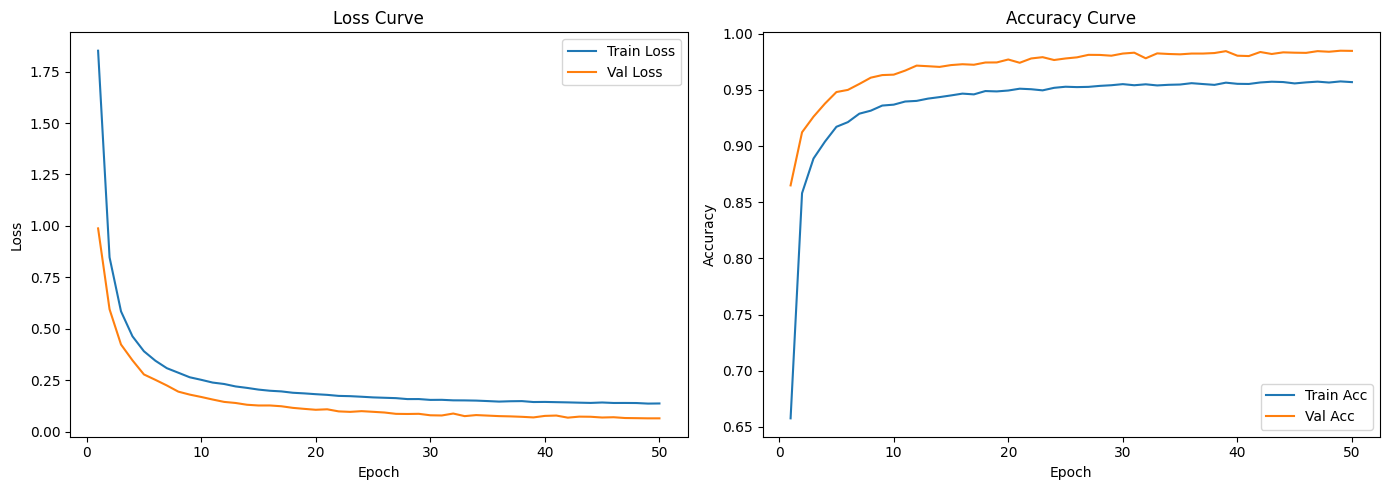

In [48]:
# ========== Train and visualize ==========
history = train_model(model, train_loader, val_loader, num_epochs)
plot_history(history)

In [7]:
# ========== Model Evaluation ==========
model = models.mobilenet_v2(pretrained=False)
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features, num_classes)
)
model.load_state_dict(torch.load("models/best_mobilenetv2.pth", map_location=device))
model = model.to(device)
model.eval()

D:\Users\Manson\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Manson\AppData\Local\Temp\ipykernel_21780\2632587094.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [8]:
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ========== Output evaluation indicators ==========
precision = precision_score(all_labels, all_preds, average='macro')
recall    = recall_score(all_labels, all_preds, average='macro')
f1        = f1_score(all_labels, all_preds, average='macro')
acc       = accuracy_score(all_labels, all_preds)

print(f"\nPrecision = {precision:.4f}")
print(f"Recall    = {recall:.4f}")
print(f"F1 Score  = {f1:.4f}")
print(f"Accuracy  = {acc:.2%}")

Testing:   0%|          | 0/408 [00:00<?, ?it/s]


Precision = 0.9885
Recall    = 0.9885
F1 Score  = 0.9885
Accuracy  = 98.84%


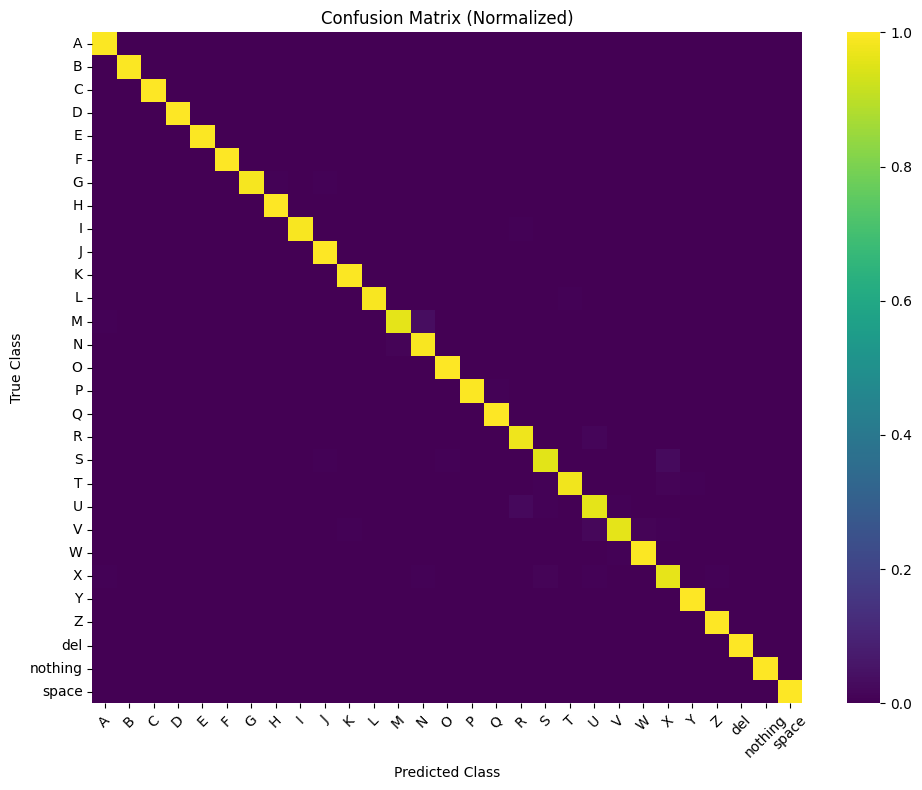

In [10]:
# ========== Confusion Matrix Visualization ==========
cm      = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, cmap="viridis",
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes,
            annot=False, fmt=".2f")
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted Class"); plt.ylabel("True Class")
plt.xticks(rotation=45); plt.yticks(rotation=0)
plt.tight_layout(); 
plt.show()